<a href="https://colab.research.google.com/github/Think-JIn99/GDSC_AI-ML/blob/main/Jeong_week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdrive_dataset

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 71.6 MB/s 


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from konlpy.tag import Komoran
from konlpy.tag import Kkma
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [5]:
from gdrivedataset import loader
file_id = '1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i'
loader.load_from_google_drive(file_id)
DATA_DIR = 'data/dataset'

========== files ============

data/dataset



In [6]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [7]:
train.head() #데이터 형태 확인

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [8]:
train.isna().sum() #결측치 확인

id          0
document    0
label       0
dtype: int64

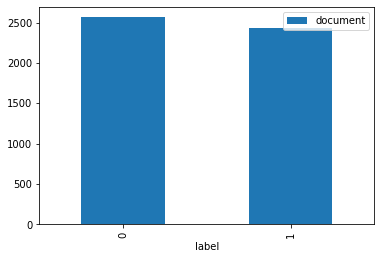

In [9]:
#id는 필요없는 속성이므로 제거해준다.
train = train.drop(['id'],axis=1)
train.groupby('label').count().plot.bar()

데이터의 비율이 일정하고 라벨링 또한 전부 돼있으므로 지도학습으로 접근한다.
분류 문제이므로 기본적인 로지스틱 회귀를 사용하거나 SVM을 활용한다.

In [10]:
def remove_stop_words(data,stop_words):
  pattern = '|'.join(stop_words)
  data = data.apply('#'.join)
  reviews = data.replace(pattern,'',regex=True)
  return reviews

def remove_none_alpha(data):
  none_words_pattern = '[^a-z|A-Z|0-9|ㄱ-ㅎ|가-힣|]' #특수문자를 전부 제거해준다.
  reviews = data.replace(none_words_pattern,'',regex=True)
  return reviews

def tokenize(data):
  ko = Komoran() #토크나이징을 실시한다.
  kk = Kkma()
  tokens = []
  for s in data:
    token = ko.morphs(s)
    if len(token) < 2: #코모란으로 못자르는 경우 kkma로 별도로 한번더 잘라줬습니다.
      token = kk.morphs(s)
    tokens.append(token)
  return tokens

def pre_process(df,stop_words):
  df['document'] = remove_none_alpha(df['document'])
  df['tokens'] = tokenize(df['document'])
  df['tokens'] = remove_stop_words(df['tokens'],stop_words)
  return df

 #토큰화를 실행한 이후 많이 사용되는 단어를 찾아보자.(긍,부)

In [11]:
#특수문자,불용어제거, 토큰화를 실행한다.
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','[ㄱ-ㅎ]'] #한글자로 구성된 토큰도 삭제해준다.
pre_processed = pre_process(train, stop_words)[['tokens','label']]
pre_processed

,tokens,label
0,영상#나#음악##쁘#다#하#아#미화#시키##불륜#일#뿐,0
1,히치콕##영화##보#았#다면#분#명#박수##치#었#을#듯,1
2,괜찮##음악#영화##또#나오#았#군요#따#아#뜻하##겨울##되##것#같#아요,1
3,아무래#20#년대#지난#작품##라#지금#보기##너무#유치#하#다,0
4,지금#까지##영화###그렇#었#듯#영화#역#시#일본##대하##미#화###어#전하#다,0
...,...,...
4995,좋##배우#로#3#류#영화##찍##안타깝##영화,0
4996,진짜#드럽#게#재미없#다#드#워드#호#퍼그#림##배경#빼#고#보#게#아니##영화,0
4997,장#실망#스럽##영화#지금#까지#보##영화#중,0
4998,런#평점#테러#네버#서##막#아야#하##것#아니#,1


In [12]:
def cleaning_tokens(data):
  temp = data.apply(lambda x: x.split('#')) #전처리를 일차적으로 처리한 토큰들
  tokens = []
  for t in temp:
    tokens.append(list(filter(lambda x: len(x) > 0, t)))
  return pd.Series(tokens)

def get_freq_count(tokens):
  pos_token = tokens[pre_processed['label'] == 1]
  neg_token = tokens[pre_processed['label'] == 0]
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

def remove_doubled_words(pos_freq,neg_freq,tokens):
  top_50_pos = pos_freq[:20]
  top_50_neg = neg_freq[:20]
  remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
  tokens_removed = remove_stop_words(tokens, remove_words)
  final_tokens = cleaning_tokens(tokens_removed)
  return final_tokens

In [13]:
tokens = cleaning_tokens(pre_processed['tokens'])
word_freq = pd.Series(np.concatenate([w for w in tokens])).value_counts()
word_freq

하     2086
다     1926
영화    1636
보     1256
고     1067
      ... 
정려       1
무척       1
씩씩       1
벨보       1
장재       1
Length: 6161, dtype: int64

긍정,부정에서 모두 사용되는 단어는 의미 없는 단어이므로 제거해준다.

In [14]:
def draw_top_hist(data,name,color):
  top_10 = data[:10]
  plt.figure(figsize=(12,7.5))
  plt.rc('font', family='NanumBarunGothic') 
  plt.suptitle("Bar Plot", fontsize=30)
  plt.title(name, fontsize=15)
  plt.bar(top_10.index,top_10.values, width=0.5, color= color, alpha=0.5)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [15]:
pos_freq, neg_freq = get_freq_count(tokens)

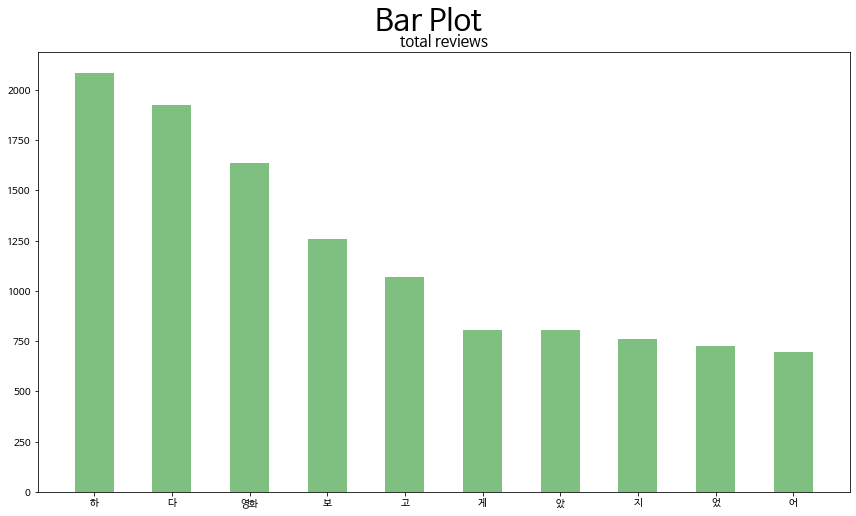

In [16]:
draw_top_hist(word_freq,'total reviews','g')

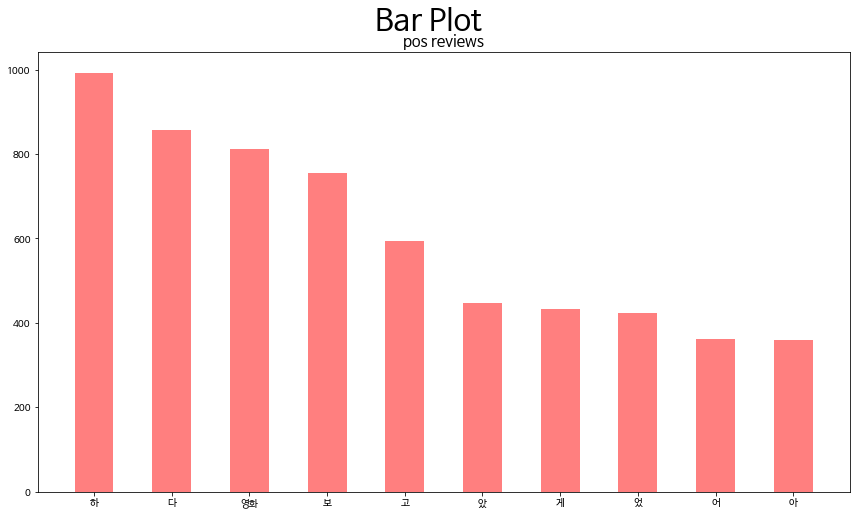

In [17]:
draw_top_hist(pos_freq,'pos reviews','r')

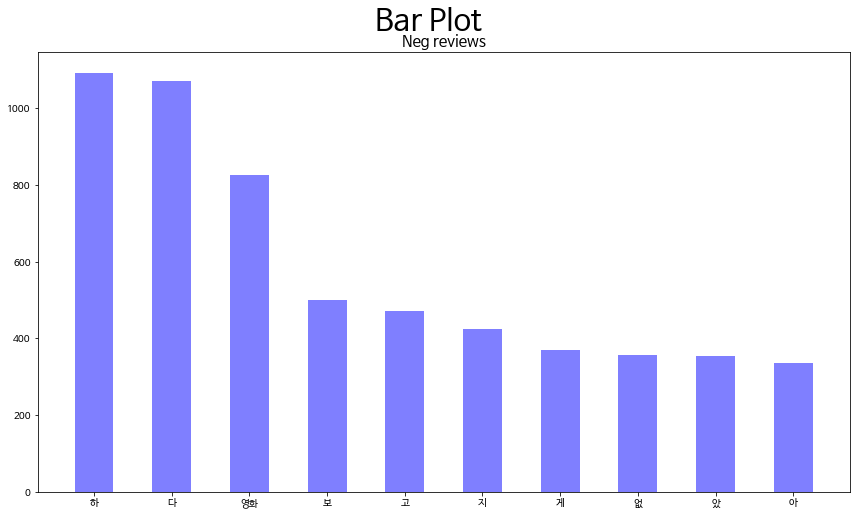

In [18]:
draw_top_hist(neg_freq,'Neg reviews','b')

겹치는 조사가 생각보다 많다. 상위 20위에 공동으로 존재하는 토큰들은 전부 제거해주자.

In [19]:
top_50_pos = pos_freq[:20]
top_50_neg = neg_freq[:20]
remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
remove_words

['하', '다', '영화', '보', '고', '았', '게', '었', '어', '아', '지', '을', '데', '만']

In [20]:
total = word_freq.sum()
removed = word_freq[remove_words].sum()
print(f'total: {total} removed: {removed} ratio:{removed / total:.2f}')

total: 56176 removed: 14165 ratio:0.25


이제 다시금 삭제할 단어들을 불용어로 처리해 제거해 줍니다.

In [21]:
tokens_removed = remove_stop_words(tokens, remove_words)
tokens_removed

0                영상#나#음악#쁘####미화#시키#불륜#일#뿐
1                    히치콕####면#분#명#박수#치###듯
2          괜찮#음악##또#나오##군요#따##뜻#겨울#되#것#같#요
3              무래#20#년대#난#작품#라#금#기#너무#유치##
4             금#까##그렇##듯##역#시#일본#대#미#화##전#
                       ...                
4995                    좋#배우#로#3#류##찍#안타깝#
4996    진짜#드럽##재미없##드#워드#호#퍼그#림#배경#빼####니#
4997                      장#실망#스럽##금#까###중
4998                 런#평점#테러#네버#서#막#야##것#니
4999      여주인공#전작#서#귀엽###여#기선#완전#망###네#실망#
Length: 5000, dtype: object

다시 긍,부정에서 많이 쓰이는 토큰 데이터를 확인해보자.

In [22]:
final_tokens = cleaning_tokens(tokens_removed)
final_tokens

0                [영상, 나, 음악, 쁘, 미화, 시키, 불륜, 일, 뿐]
1                        [히치콕, 면, 분, 명, 박수, 치, 듯]
2       [괜찮, 음악, 또, 나오, 군요, 따, 뜻, 겨울, 되, 것, 같, 요]
3            [무래, 20, 년대, 난, 작품, 라, 금, 기, 너무, 유치]
4             [금, 까, 그렇, 듯, 역, 시, 일본, 대, 미, 화, 전]
                          ...                    
4995                     [좋, 배우, 로, 3, 류, 찍, 안타깝]
4996     [진짜, 드럽, 재미없, 드, 워드, 호, 퍼그, 림, 배경, 빼, 니]
4997                         [장, 실망, 스럽, 금, 까, 중]
4998               [런, 평점, 테러, 네버, 서, 막, 야, 것, 니]
4999       [여주인공, 전작, 서, 귀엽, 여, 기선, 완전, 망, 네, 실망]
Length: 5000, dtype: object

In [23]:
pos_freq,neg_freq = get_freq_count(final_tokens)

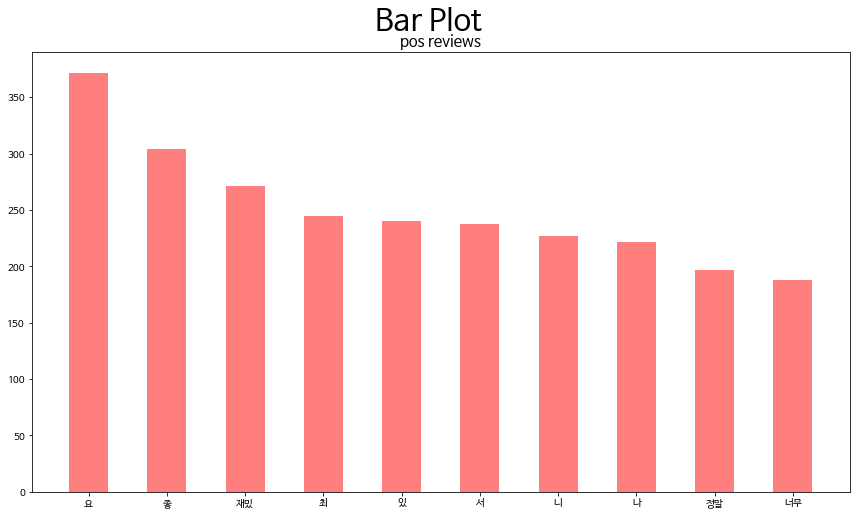

In [24]:
draw_top_hist(pos_freq,'pos reviews','r') #다시 그린 긍정리뷰 빈도수 히스토그램

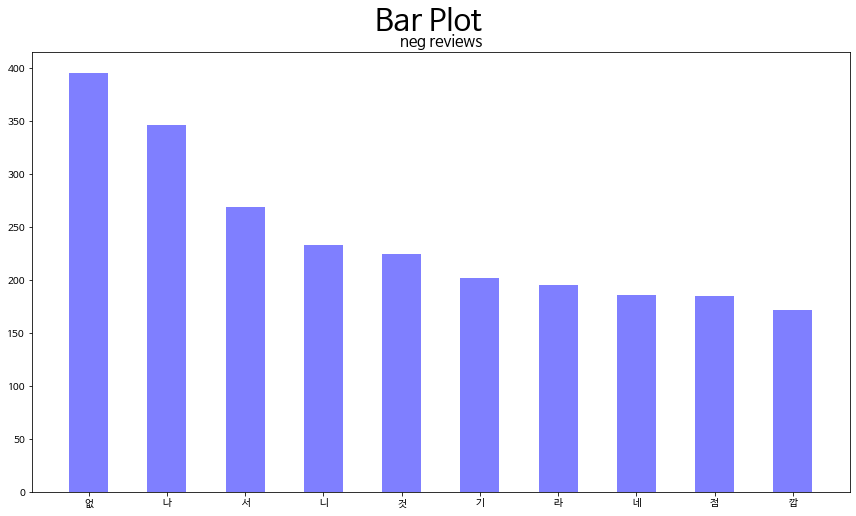

In [25]:
draw_top_hist(neg_freq,'neg reviews','b') #다시 그린 긍정리뷰 빈도수 히스토그램

공통으로 많이 사용하는 단어들을 제외하고 나니 부정과 긍정에서 사용하는 단어의 차이를 확인 할 수 있었습니다. 이제 벡터화를 진행해 봅시다.

단어의 수가 너무 많다는 생각이 들지 않나요? 6천개의 단어가 꼭 전부 필요할까요? 
한번만 등장하는 단어도 모두 고려해서 학습시켜야 할까요?

Text(0.5, 0.98, '1888 words explain 90.0% of total words dirtribution')

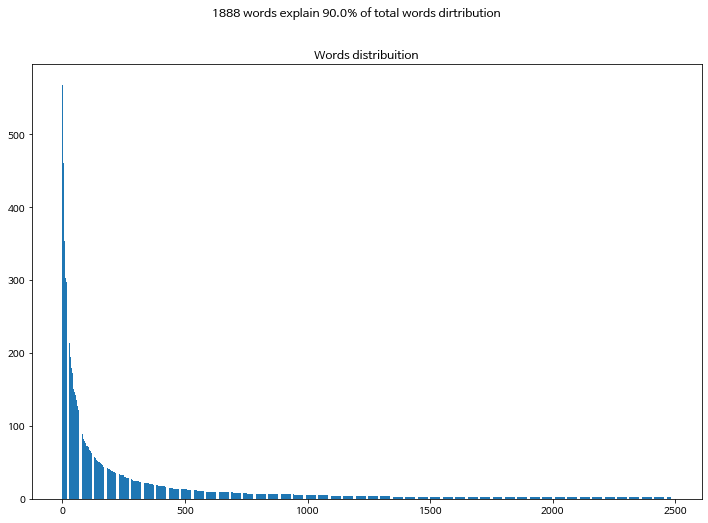

In [26]:
final_freq = pd.Series(np.concatenate([w for w in final_tokens])).value_counts()
words_distribution = final_freq[final_freq > 1] #1번 이상 등장하는 단어들의 수
accumulate_words = np.add.accumulate(words_distribution)
ratio = 0.90
over_point = np.where(accumulate_words > sum(final_freq) * ratio)[0][0]
plt.figure(figsize=(12,8))
plt.bar(range(0,len(words_distribution)),words_distribution.values)
plt.title('Words distribuition')
plt.suptitle(f'{over_point} words explain {ratio * 100}% of total words dirtribution')

더 적은 단어를 사용하고도 충분히 문장을 전부 파악할 수 있습니다.


In [27]:
final_tokens

0                [영상, 나, 음악, 쁘, 미화, 시키, 불륜, 일, 뿐]
1                        [히치콕, 면, 분, 명, 박수, 치, 듯]
2       [괜찮, 음악, 또, 나오, 군요, 따, 뜻, 겨울, 되, 것, 같, 요]
3            [무래, 20, 년대, 난, 작품, 라, 금, 기, 너무, 유치]
4             [금, 까, 그렇, 듯, 역, 시, 일본, 대, 미, 화, 전]
                          ...                    
4995                     [좋, 배우, 로, 3, 류, 찍, 안타깝]
4996     [진짜, 드럽, 재미없, 드, 워드, 호, 퍼그, 림, 배경, 빼, 니]
4997                         [장, 실망, 스럽, 금, 까, 중]
4998               [런, 평점, 테러, 네버, 서, 막, 야, 것, 니]
4999       [여주인공, 전작, 서, 귀엽, 여, 기선, 완전, 망, 네, 실망]
Length: 5000, dtype: object

In [28]:
extract_word = words_distribution[over_point + 1:].index
extracted_tokens = remove_stop_words(final_tokens, extract_word)
extracted_tokens = cleaning_tokens(extracted_tokens)
extracted_tokens

0                [영상, 나, 음악, 쁘, 미화, 시키, 불륜, 일, 뿐]
1                             [면, 분, 명, 박수, 치, 듯]
2       [괜찮, 음악, 또, 나오, 군요, 따, 뜻, 겨울, 되, 것, 같, 요]
3            [무래, 20, 년대, 난, 작품, 라, 금, 기, 너무, 유치]
4             [금, 까, 그렇, 듯, 역, 시, 일본, 대, 미, 화, 전]
                          ...                    
4995                     [좋, 배우, 로, 3, 류, 찍, 안타깝]
4996     [진짜, 드럽, 재미없, 드, 워드, 호, 퍼그, 림, 배경, 빼, 니]
4997                         [장, 실망, 스럽, 금, 까, 중]
4998               [런, 평점, 테러, 네버, 서, 막, 야, 것, 니]
4999       [여주인공, 전작, 서, 귀엽, 여, 기선, 완전, 망, 네, 실망]
Length: 5000, dtype: object

In [29]:
#tfidf를 활용해 벡터화를 진행합니다.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [30]:
def make_dataset(tokens):
  train_tokens = tokens.apply(' '.join) #중복 단어를 제거한 토큰들을 문자열로 합쳐준다.
  X = train_tokens
  y = train['label']
  X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=2) #학습 데이터와 검증 데이터를 분리한다.
  return X_train, X_eval, y_train, y_eval

In [31]:
def tune_hyper_parameter(X_train, X_eval, y_train, y_eval):
  fit_max_feature = 0
  fit_c = 0
  max_f1 = 0
  for i in range(100, len(final_freq), 100):
    vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf=True,ngram_range=(1,3),max_features=i) #전체 단어의 수는 6천개 정도 된다.
    X_train_vector = vectorizer.fit_transform(X_train)
    X_eval_vector = vectorizer.transform(X_eval)
    for c in [0.01,0.03,0.1,0.3,1,3,10]:
        lgs = LogisticRegression(class_weight = 'balanced',max_iter=2000,C = c)
        lgs.fit(X_train_vector, y_train)
        yhat = lgs.predict_proba(X_eval_vector)
        predicted = lgs.predict(X_eval_vector)
        f1 = f1_score(y_eval, predicted)
        accuracy = sum(predicted == y_eval) / len(predicted)
        print(f"Accuracy: {accuracy} f1-score: {f1}, max-features:{i}")
        if max_f1 < f1:
          fit_max_feature = i
          fit_c = c
          max_f1 = f1
  return fit_max_feature, fit_c, max_f1


In [32]:
X_train, X_eval, y_train, y_eval = make_dataset(extracted_tokens)
best_max_feature, best_cost, best_f1 = tune_hyper_parameter(X_train, X_eval, y_train, y_eval)

Accuracy: 0.694 f1-score: 0.6832298136645963, max-features:100
Accuracy: 0.697 f1-score: 0.6866597724922441, max-features:100
Accuracy: 0.704 f1-score: 0.6948453608247424, max-features:100
Accuracy: 0.719 f1-score: 0.71120246659815, max-features:100
Accuracy: 0.729 f1-score: 0.722051282051282, max-features:100
Accuracy: 0.732 f1-score: 0.7242798353909465, max-features:100
Accuracy: 0.732 f1-score: 0.7237113402061855, max-features:100
Accuracy: 0.715 f1-score: 0.7034339229968783, max-features:200
Accuracy: 0.72 f1-score: 0.7119341563786009, max-features:200
Accuracy: 0.735 f1-score: 0.7287615148413511, max-features:200
Accuracy: 0.746 f1-score: 0.7402862985685073, max-features:200
Accuracy: 0.752 f1-score: 0.751004016064257, max-features:200
Accuracy: 0.754 f1-score: 0.7544910179640719, max-features:200
Accuracy: 0.755 f1-score: 0.7552447552447552, max-features:200
Accuracy: 0.739 f1-score: 0.7317574511819116, max-features:300
Accuracy: 0.739 f1-score: 0.7328556806550665, max-features:3

In [33]:
print(f"max_feature: {best_max_feature} cost: {best_cost} f1: {best_f1}") #최적의 파라미터

max_feature: 2900 cost: 10 f1: 0.8577036310107947


In [34]:
vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf=True, ngram_range=(1,3), max_features=best_max_feature) #전체 단어의 수는 6천개 정도 된다.
X_train_vector = vectorizer.fit_transform(X_train)
X_eval_vector = vectorizer.transform(X_eval)
lgs = LogisticRegression(class_weight = 'balanced', max_iter=2000, C = best_cost)
lgs.fit(X_train_vector, y_train)
yhat = lgs.predict_proba(X_eval_vector)
yhat = yhat[:,1] #1인 경우의 확률만 구해줍니다.
predicted = lgs.predict(X_eval_vector)
f1 = f1_score(y_eval, predicted)
print(f"Accuracy: {lgs.score(X_eval_vector, y_eval)}")
print(f"f1-score: {f1}")

Accuracy: 0.855
f1-score: 0.8577036310107947


검증셋을 활용해 최적의 threshold를 찾아보자.

In [35]:
def plot_f1_curve(fy_eval, fyhat,title):
  precisions,recalls,thresholds = precision_recall_curve(fy_eval,fyhat)
  plt.figure(figsize=(12,8))
  plt.plot(recalls, precisions, marker='.', label='Logistic', color='dodgerblue')
  f1_score_list = (2 * precisions * recalls) / (precisions + recalls)
  max_index = np.argmax(f1_score_list)
  #s는 마커의 사이즈 facecolor는 마크의 내부 색상 edgecolor는 마크의 테두리 색상을 의미
  plt.scatter(recalls[max_index],precisions[max_index],marker='o',color='black',label='best',s=200,facecolors='none',edgecolors='black')
  plt.title(title)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  print('Best Threshold=%f, F-Score=%.3f' % (thresholds[max_index], f1_score_list[max_index]))
  return

Best Threshold=0.476459, F-Score=0.862


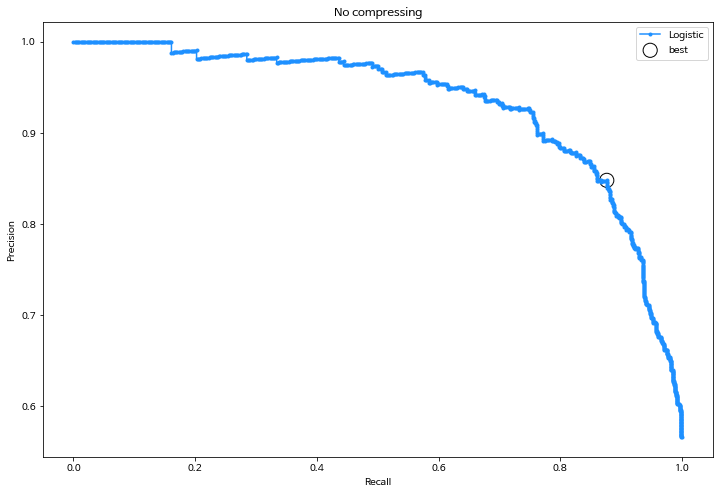

In [36]:
plot_f1_curve(y_eval, yhat,'No compressing')

이제 새로 찾은 threshold 값을 활용해 다시금 라벨링을 진행합니다.

In [37]:
threshold = 0.513917
y_pred = np.where(yhat >= threshold,1,0)
f1 = f1_score(y_eval,y_pred,average='binary')
print(f"f1:{f1}")

f1:0.8579940417080436


In [38]:
test_pre_processed = pre_process(test ,stop_words)['tokens']
test_tokens = cleaning_tokens(test_pre_processed)
t_pos_freq, t_neg_freq = get_freq_count(test_tokens)
test_final_tokens = remove_doubled_words(t_pos_freq, t_neg_freq, test_tokens)
test_final_tokens = test_final_tokens.apply(' '.join) #중복 단어를 제거한 토큰들을 문자열로 합쳐준다.
X_test = vectorizer.transform(test_final_tokens)
pred = lgs.predict(X_test)

In [39]:
#None compressed
res = pd.DataFrame()
res['id'] = test['id']
tyhat = lgs.predict_proba(X_test)
tyhat = tyhat[:,1] #1인 경우의 확률만 구해줍니다.
ty_pred = np.where(tyhat >= threshold,1,0)
res['label'] = ty_pred

In [40]:
res.to_csv('result_4000.csv',index=None)
